In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Two interacting Rydberg atoms

Say we have two atoms at some distance $R$ from each other. Each is coupled with a Rabi frequency $\Omega$ to a Rydberg state $|r\rangle$ that decays with some rate $\Gamma_r$. The detuning is $\Delta$. In that case, the Hamiltonian is given by (setting $\hbar = 1$)
$$
\mathcal{H} = \sum_{i = 1}^2 \left[ \frac{\Omega}{2} \left( |r_i\rangle\langle g_i| + |g_i\rangle\langle r_i| \right) - \Delta |r_i\rangle\langle r_i| \right] - \frac{C_6}{R^6}|rr\rangle\langle rr|,
$$
where $C_6$ is the Van der Waals coefficient.

At any time, our wave function will have the form $|\psi\rangle = \alpha|gg\rangle + \beta\left( |rg\rangle + |gr\rangle \right)/\sqrt{2} + \gamma|rr\rangle$, where the coefficients are assumed to be time dependent. Note that we have symmetrized the basis by writing $|gr\rangle$ and $|rg\rangle$ as a superposition (the superposition with the opposite sign is not coupled). When we plug this into the time-dependent Schrödinger equation we get the following differential equations for the coefficients:

\begin{align}
    \dot{\alpha} &= -i \frac{\beta\Omega}{\sqrt{2}} \\
    \dot{\beta}  &= -i \left( \frac{\left(\alpha + \gamma \right) \Omega}{\sqrt{2}} - \Delta\beta \right) \\
    \dot{\gamma} &= -i \left( \frac{\beta\Omega}{\sqrt{2}} - 2\Delta\gamma - \frac{C_6}{R^6}\gamma \right).
\end{align}

For now we ignore decay, and just simulate the on-resonant evolution ($\Delta = 0$) using the Euler method. Let's specify the relevant parameters:

In [2]:
Omega = 2*np.pi
delta = 0
Gamma = 0
C6 = 25
R = 1

Define the function that takes a step; this already contains the dephasing parameters, but let's just forget about these for now.

In [3]:
def step(alpha, beta, gamma):
    alphaN = alpha - 1j * dt * ( Omega * beta / np.sqrt(2) )
    betaN = beta - 1j * dt * ( Omega * (alpha + gamma) / np.sqrt(2) - delta*beta - 1j*Gamma*beta/2)
    gammaN = gamma - 1j * dt * ( Omega * beta / np.sqrt(2) - 2*delta*gamma - C6/R**6 * gamma - 1j*Gamma*gamma)

    return alphaN, betaN, gammaN

We need some small time step, otherwise the Euler method runs amok:

In [4]:
dt = 1/100000
timeax = np.arange(0,1,dt)

Run a trajectory:

In [5]:
alphaO = 1.0
betaO = 0.0
gammaO = 0.0

alpha = np.zeros(len(timeax), dtype=complex)
beta = np.zeros(len(timeax), dtype=complex)
gamma = np.zeros(len(timeax), dtype=complex)


alpha[0] = alphaO
beta[0] = betaO
gamma[0] = gammaO

for i in range(1, len(timeax)):
    (alphaO, betaO, gammaO) = step(alphaO, betaO, gammaO)

    alpha[i] = alphaO
    beta[i] = betaO
    gamma[i] = gammaO

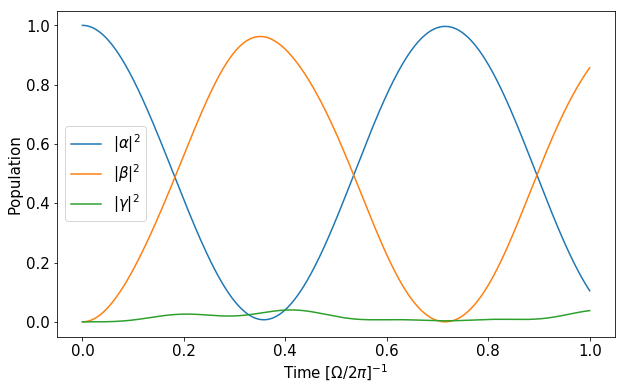

In [6]:
fig, ax = plt.subplots(1,1, figsize = (10, 6))
ax.plot(timeax, np.abs(alpha)**2, label = r'$|\alpha|^2$')
ax.plot(timeax, np.abs(beta)**2, label = r'$|\beta|^2$')
ax.plot(timeax, np.abs(gamma)**2, label = r'$|\gamma|^2$')

ax.set_xlabel(r'Time $[\Omega/2\pi]^{-1}$', fontsize = 15)
ax.set_ylabel('Population', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)

ax.legend(fontsize = 15)
plt.show()

### Add in decoherence using QMC

In the quantum Monte Carlo wave function method we need to add non-Hermitian terms to the Hamiltonian, to simulate the decay of population. In general this takes the form $\frac{i\Gamma}{2}|e\rangle\langle e|$, where $|e\rangle$ is any excited state. In our case we have two excited states, one of which decays at twice the rate of the other one. Knowing that, we can formulate the following update rules:
\begin{align}
    \alpha &\mapsto \alpha -i \, dt \frac{\beta\Omega}{\sqrt{2}} \\
    \beta  &\mapsto \beta -i \, dt \left( \frac{\left(\alpha + \gamma \right) \Omega}{\sqrt{2}} - \Delta\beta - \frac{i\Gamma_r}{2}\beta \right) \\
    \gamma &\mapsto \gamma -i \, dt \left( \frac{\beta\Omega}{\sqrt{2}} - 2\Delta\gamma - \frac{C_6}{R^6}\gamma - i\Gamma_r\gamma \right).
\end{align}
Luckily, these are already accounted for in the `step()` function defined above. We can set $\Gamma_r$ to some nonzero value and see what happens:

In [12]:
Gamma = Omega/2

To properly do Monte Carlo we need to toss a coin after every step `dt` to see whether an atom has decayed. 

In [8]:
def MCTrajectory(ntraj):
    # Make some space
    alphaPop = np.zeros(len(timeax), dtype=complex)
    betaPop = np.zeros(len(timeax), dtype=complex)
    gammaPop = np.zeros(len(timeax), dtype=complex)
    
    for traj in range(ntraj):
        # Initial conditions
        alphaO = 1.0
        betaO = 0.0
        gammaO = 0.0
        
        # Define first points
        alphaPop[0] = alphaO
        betaPop[0] = betaO
        gammaPop[0] = gammaO

        # Draw all MC numbers now, saves time later
        rs1 = np.random.random(len(timeax))
        rs2 = np.random.random(len(timeax))

        for i in range(1, len(timeax)):
            # Step 1. Update populations
            (alphaO, betaO, gammaO) = step(alphaO, betaO, gammaO)

            # Step 2. Do we make a jump?
            dpbeta = Gamma*dt*np.abs(betaO)**2
            r1 = rs1[i]
            
            dpgamma = 2*Gamma*dt*np.abs(gammaO)**2
            r2 = rs2[i]
            
            if r1 <= dpbeta:
                # We make a jump from |rg> + |gr> back to |gg>
                alphaO = np.sqrt(np.abs(alphaO)**2 + np.abs(betaO)**2)
                betaO = 0.0
            
            elif r2 <= dpgamma:
                # We make a jump from |rr> back to |rg> + |gr>
                betaO = np.sqrt(np.abs(betaO)**2 + np.abs(gammaO)**2)
                gammaO = 0.0
                
            else:
                # We don't make a jump; renormalize the wave function
                alphaO = alphaO / np.sqrt(1 - dpbeta - dpgamma)
                betaO = betaO / np.sqrt(1 - dpbeta - dpgamma)
                gammaO = gammaO / np.sqrt(1 - dpbeta - dpgamma)

            # Store populations
            alphaPop[i] += np.abs(alphaO)**2 / ntraj
            betaPop[i] += np.abs(betaO)**2 / ntraj
            gammaPop[i] += np.abs(gammaO)**2 / ntraj
    return alphaPop, betaPop, gammaPop

Define some time axis:

In [9]:
dt = 1/5000
timeax = np.arange(0,0.5,dt)

Run a number of trajectories, compare with and without interactions:

In [13]:
numtrajs = 500

C6 = 0
(alphaPopsNoC6, betaPopsNoC6, gammaPopsNoC6) = MCTrajectory(numtraj)

C6 = 25
(alphaPopsYesC6, betaPopsYesC6, gammaPopsYesC6) = MCTrajectory(numtraj)

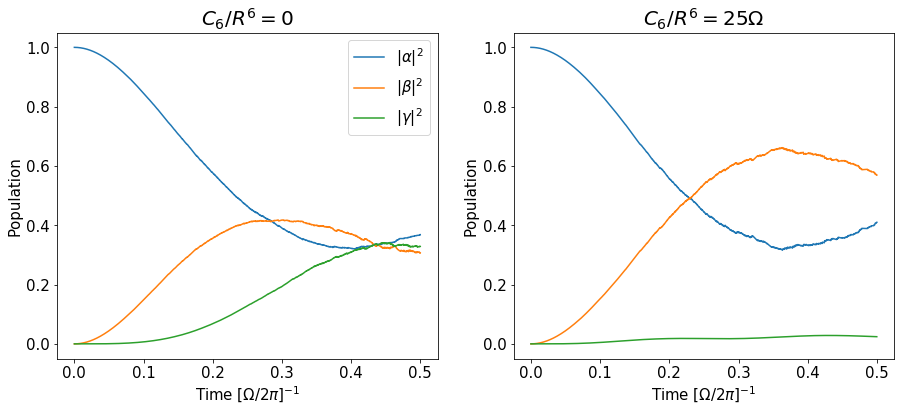

In [24]:
fig, ax = plt.subplots(1, 2, figsize= (15, 6))

ax[0].plot(timeax, np.real(alphaPopsNoC6), label = r'$|\alpha|^2$')
ax[0].plot(timeax, np.real(betaPopsNoC6), label = r'$|\beta|^2$')
ax[0].plot(timeax, np.real(gammaPopsNoC6), label = r'$|\gamma|^2$')

ax[1].plot(timeax, np.real(alphaPopsYesC6), label = r'$|\alpha|^2$')
ax[1].plot(timeax, np.real(betaPopsYesC6), label = r'$|\beta|^2$')
ax[1].plot(timeax, np.real(gammaPopsYesC6), label = r'$|\gamma|^2$')

for i in range(2):
    ax[i].set_xlabel(r'Time $[\Omega/2\pi]^{-1}$', fontsize = 15)
    ax[i].set_ylabel('Population', fontsize = 15)
    ax[i].tick_params(axis='both', which='major', labelsize = 15)

ax[0].set_title(r'$C_6/R^6 = 0$', fontsize = 20) 
ax[1].set_title(r'$C_6/R^6 = 25 \Omega$', fontsize = 20)

ax[0].legend(fontsize = 15)

plt.show()